In [1]:
from utils import *
from extract_feature_AE import *
from extract_feature_PCA import *

In [2]:
import numpy as np
np.random.seed(42)

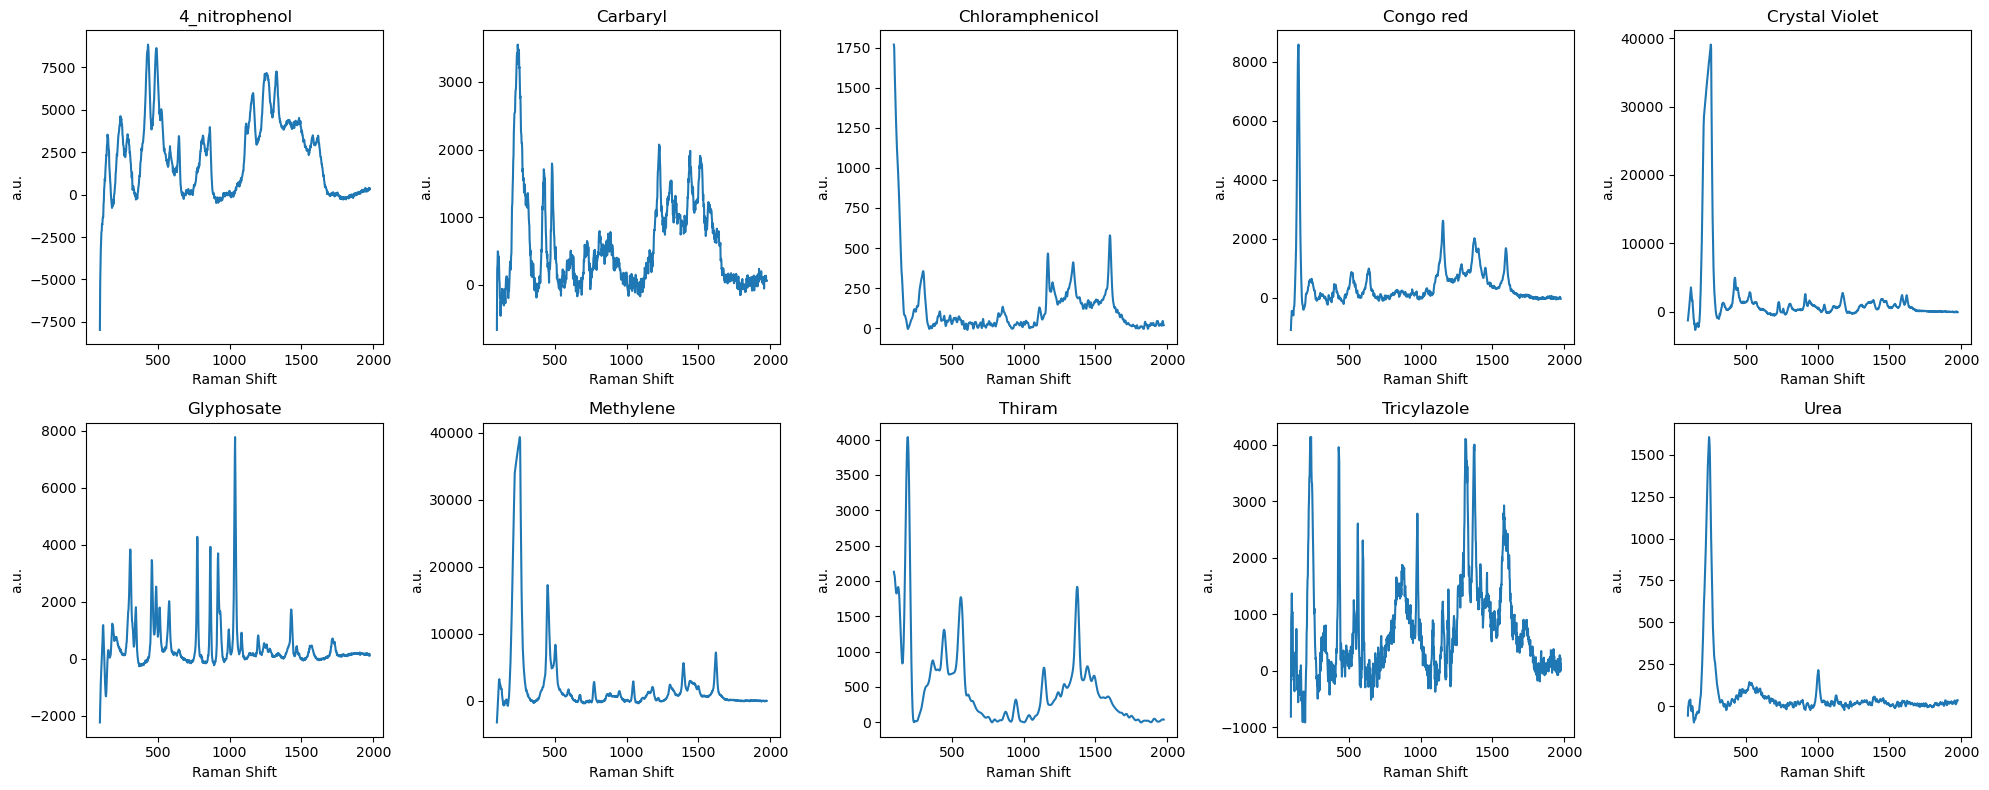

In [3]:
plot_data(paths, labels, file_names[0], 2, 5, figsize = (20, 8))

In [4]:
X, y = make_data(paths, 34)
print(X.shape, y.shape)
X_max = X.max(axis = 0, keepdims = True)
X_min = X.min(axis = 0, keepdims = True)

(50, 34) (50, 1)


In [5]:
X = Norm(X)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.4, stratify=y, shuffle= True, random_state= 42)

In [7]:
y_test

array([[0.],
       [9.],
       [3.],
       [4.],
       [8.],
       [5.],
       [2.],
       [4.],
       [6.],
       [5.],
       [2.],
       [9.],
       [7.],
       [3.],
       [0.],
       [1.],
       [8.],
       [6.],
       [1.],
       [7.]])

In [8]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(30, 34) (30, 1) (20, 34) (20, 1)


# Grid search

In [9]:
Grid_search_model(X_train,y_train, cv = 3)

Best parameters for Logistic Regression: {'C': 10.0, 'penalty': 'l2', 'solver': 'liblinear'}, score: 0.87
Time taken for Logistic Regression: 0.07 seconds

Best parameters for SVM: {'C': 10.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'shrinking': True}, score: 0.70
Time taken for SVM: 0.29 seconds

Best parameters for KNN: {'algorithm': 'auto', 'metric': 'cosine', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}, score: 0.97
Time taken for KNN: 1.92 seconds

Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'random'}, score: 0.57
Time taken for Decision Tree: 0.43 seconds

Best parameters for Random Forest: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 42}, score: 0.80
Time taken for Random Forest: 55.92 seconds

Best parameters for Naive Bayes: {'alpha': 0.01}, score: 0.10
Time taken for Naive Baye

In [10]:
models = [LogisticRegression(C = 10, penalty = 'l2', solver = 'liblinear'),
          SVC(C = 10, degree = 2, gamma = 'scale', kernel = 'linear', shrinking = True,  probability=True),
          KNeighborsClassifier(algorithm = 'auto', metric = 'cosine', n_neighbors = 1, p = 1, weights = 'uniform'),
          DecisionTreeClassifier(criterion= 'entropy', max_depth= 6, min_samples_leaf= 1, min_samples_split = 2, splitter= 'random',  random_state = 42),
          RandomForestClassifier(criterion = 'gini', max_depth = 4, min_samples_leaf = 1, min_samples_split = 5, n_estimators = 100,  random_state = 42),
          BernoulliNB(alpha=0.01)]

In [11]:
for i, model in enumerate(models):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_train, y_train)
    file_name = f"./model/{type(models[i]).__name__}.pkl"
    save_model(file_name, model)


Model './model/LogisticRegression.pkl' already saved
Model './model/SVC.pkl' already saved
Model './model/KNeighborsClassifier.pkl' already saved
Model './model/DecisionTreeClassifier.pkl' already saved
Model './model/RandomForestClassifier.pkl' already saved
Model './model/BernoulliNB.pkl' already saved


Testing with BernoulliNB
Accuracy: 0.1000
Precision: 0.0100
Recall: 0.1000
F1-score: 0.0182
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[[0. 9. 3. 4. 8. 5. 2. 4. 6. 5. 2. 9. 7. 3. 0. 1. 8. 6. 1. 7.]]


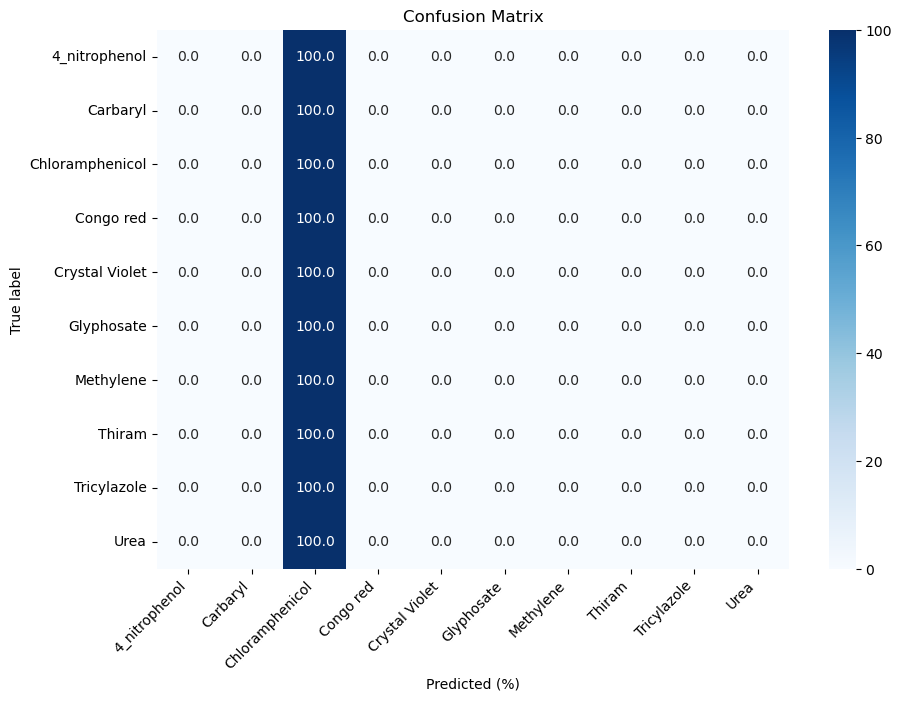

In [12]:
print(model_predict(X_test, y_test, models[5])['Predict'])
print(y_test.T)

# Boosting

In [13]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier

ensemble_clf = VotingClassifier(
    estimators=[
        ('logistic', models[0]),
        ('svc', models[1]),
        ('random_forest', models[4]),
    ],
    voting='soft'
)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ensemble_clf.fit(X_train, y_train)

boosting_clf = AdaBoostClassifier(
    estimator=ensemble_clf,
    n_estimators=10,
    learning_rate=1.0
)
boosting_clf.fit(X_train, y_train.ravel())


AdaBoostClassifier(estimator=VotingClassifier(estimators=[('logistic',
                                                           LogisticRegression(C=10,
                                                                              solver='liblinear')),
                                                          ('svc',
                                                           SVC(C=10, degree=2,
                                                               kernel='linear',
                                                               probability=True)),
                                                          ('random_forest',
                                                           RandomForestClassifier(max_depth=4,
                                                                                  min_samples_split=5,
                                                                                  random_state=42))],
                                              voting='soft'),
                   n_estimators=10)

Testing with AdaBoostClassifier
Accuracy: 0.6500
Precision: 0.5667
Recall: 0.6500
F1-score: 0.5800
[3. 2. 3. 6. 8. 5. 2. 6. 6. 5. 2. 2. 4. 3. 0. 1. 8. 6. 1. 9.]
[[0. 9. 3. 4. 8. 5. 2. 4. 6. 5. 2. 9. 7. 3. 0. 1. 8. 6. 1. 7.]]


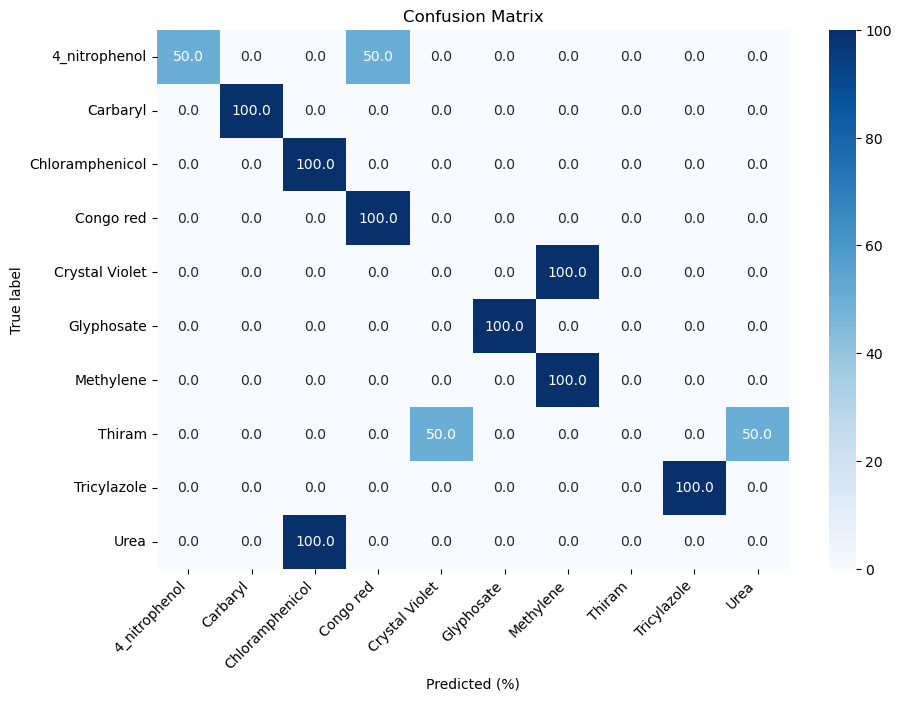

In [14]:
print(model_predict(X_test, y_test, boosting_clf)['Predict'])
print(y_test.T)

# Ensemble

In [15]:
ensemble_clf = VotingClassifier(
    estimators=[
        ('logistic', models[0]),
        ('svm', models[1]),
        ('knn', models[2]),
        ('random', models[4]),
    ],
    voting='soft'
)

ensemble_clf.fit(X_train, y_train.ravel())

VotingClassifier(estimators=[('logistic',
                              LogisticRegression(C=10, solver='liblinear')),
                             ('svm',
                              SVC(C=10, degree=2, kernel='linear',
                                  probability=True)),
                             ('knn',
                              KNeighborsClassifier(metric='cosine',
                                                   n_neighbors=1, p=1)),
                             ('random',
                              RandomForestClassifier(max_depth=4,
                                                     min_samples_split=5,
                                                     random_state=42))],
                 voting='soft')

Testing with VotingClassifier
Accuracy: 0.9500
Precision: 0.9667
Recall: 0.9500
F1-score: 0.9467
[3. 9. 3. 4. 8. 5. 2. 4. 6. 5. 2. 9. 7. 3. 0. 1. 8. 6. 1. 7.]
[[0. 9. 3. 4. 8. 5. 2. 4. 6. 5. 2. 9. 7. 3. 0. 1. 8. 6. 1. 7.]]


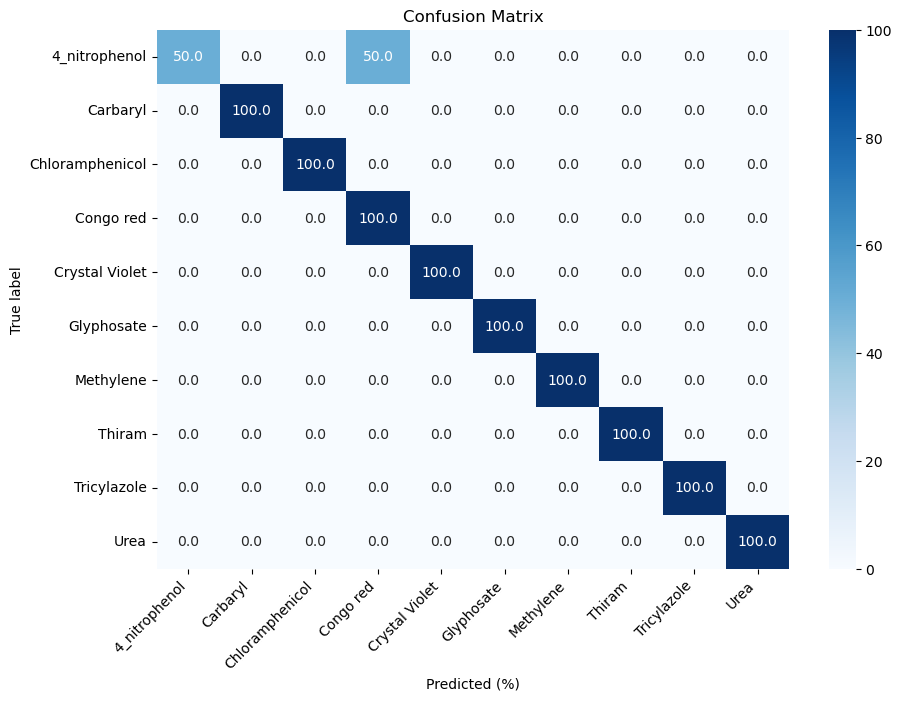

In [16]:
print(model_predict(X_test, y_test, ensemble_clf)['Predict'])
print(y_test.T)

In [17]:
proba = ensemble_clf.predict_proba(X_test)
proba[0]


array([0.04996794, 0.07038555, 0.14081158, 0.37043104, 0.07216912,
       0.02750662, 0.06438791, 0.08591359, 0.01824182, 0.10018481])

# Testing

In [18]:
Trycilazole = ['test_Tricylazole/Tricyclazole-1.txt','test_Tricylazole/Tricyclazole-2.txt','test_Tricylazole/Tricyclazole-3.txt',
               'test_Tricylazole/Tricyclazole-4.txt','test_Tricylazole/Tricyclazole-5.txt']
for i in range(5):
    print(model_predict(X_test, y_test, models[0], path = Trycilazole[i])['Predict'])

Testing with LogisticRegression
[8.]
Testing with LogisticRegression
[8.]
Testing with LogisticRegression
[8.]
Testing with LogisticRegression
[8.]
Testing with LogisticRegression
[8.]


In [19]:
for i in range(5):
    print(model_predict(X_test, y_test, models[1], path = Trycilazole[i])['Predict'])

Testing with SVC
[8.]
Testing with SVC
[8.]
Testing with SVC
[8.]
Testing with SVC
[8.]
Testing with SVC
[8.]


In [20]:
for i in range(5):
    print(model_predict(X_test, y_test, models[2], path = Trycilazole[i])['Predict'])

Testing with KNeighborsClassifier
[8.]
Testing with KNeighborsClassifier
[8.]
Testing with KNeighborsClassifier
[8.]
Testing with KNeighborsClassifier
[8.]
Testing with KNeighborsClassifier
[1.]


In [21]:
for i in range(5):
    print(model_predict(X_test, y_test, models[3], path = Trycilazole[i])['Predict'])

Testing with DecisionTreeClassifier
[8.]
Testing with DecisionTreeClassifier
[8.]
Testing with DecisionTreeClassifier
[8.]
Testing with DecisionTreeClassifier
[8.]
Testing with DecisionTreeClassifier
[8.]


In [22]:
for i in range(5):
    print(model_predict(X_test, y_test, models[4], path = Trycilazole[i])['Predict'])

Testing with RandomForestClassifier
[8.]
Testing with RandomForestClassifier
[8.]
Testing with RandomForestClassifier
[8.]
Testing with RandomForestClassifier
[8.]
Testing with RandomForestClassifier
[1.]


In [23]:
for i in range(5): 
    print(model_predict(X_test, y_test, ensemble_clf, path = Trycilazole[i])['Predict'])

Testing with VotingClassifier
[8.]
Testing with VotingClassifier
[8.]
Testing with VotingClassifier
[8.]
Testing with VotingClassifier
[8.]
Testing with VotingClassifier
[1.]


Testing with VotingClassifier
Testing with VotingClassifier
Testing with VotingClassifier
Testing with VotingClassifier
Testing with VotingClassifier


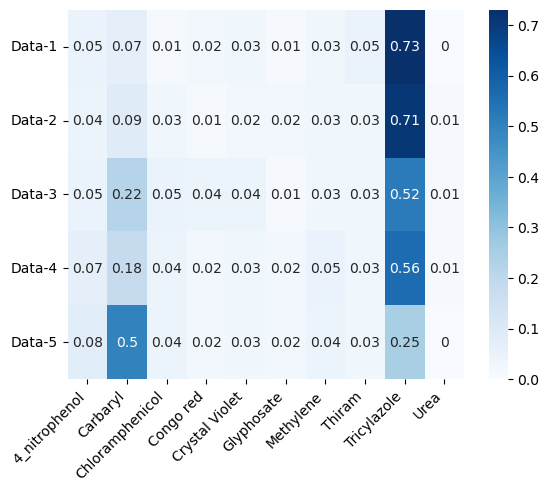

In [24]:
probabilities = []
Trycilazole_1 = ['Data-1','Data-2','Data-3',
               'Data-4','Data-5']
for i in range(5):
    result = model_predict(X_test, y_test, ensemble_clf, path=Trycilazole[i])
    probabilities.append(result['Probability'])

probabilities_array = np.array(probabilities)
import seaborn as sn
sn.heatmap(probabilities_array.reshape(5,10), annot= True, cmap= "Blues")
plt.xticks(np.arange(len(labels)) + 0.5, labels, rotation=45, ha="right")
plt.yticks(np.arange(len(Trycilazole_1)) + 0.5, Trycilazole_1, rotation=0)
# plt.xlabel("Predicted (%)")
# plt.ylabel("True label")
plt.savefig(f"./plots/test_data_ensemble.png")


In [25]:
def plot_Tricylazole(paths, nrows, ncols, figsize):
    fig, axes = plt.subplots(nrows= nrows, ncols= ncols, figsize= figsize)
    axes = axes.flatten()

    for i, path in enumerate(paths):
        data = pd.read_csv(path, sep="\t")
        x = data.iloc[-1000:, 0].values
        y = data.iloc[-1000:, 1].values
        ax = axes[i]
        ax.set_xlabel("Raman Shift")
        ax.set_ylabel("a.u.")
        ax.plot(x, y)
    plt.tight_layout()  
    plt.show()


In [26]:
from decimal import Decimal
Cm = [] 
for i in Trycilazole:
    data = pd.read_csv(i, sep="\t")
    x = my_array = np.arange(10)
    y = data.iloc[[1885, 1391, 1670, 1407, 1421, 1577, 1878, 1512, 1892, 1596], 1].values
    y_1 = data.iloc[1851:1885, 1].values
    # print(y_1)
    min_y = np.min(y_1)
    print(min_y)
    delta = y[0] - np.min(y_1)
    cm = (np.log10(float(delta))- 5.58)/0.36
    # print(cm)
    Cm.append(10**(float(cm)))
print(Cm)

-85.124
-159.882
-150.878
-122.9
-164.225
[5.158138277319984e-07, 1.5085026168468492e-07, 4.258594955224027e-08, 1.1013836049862625e-08, 5.0076027773456985e-09]


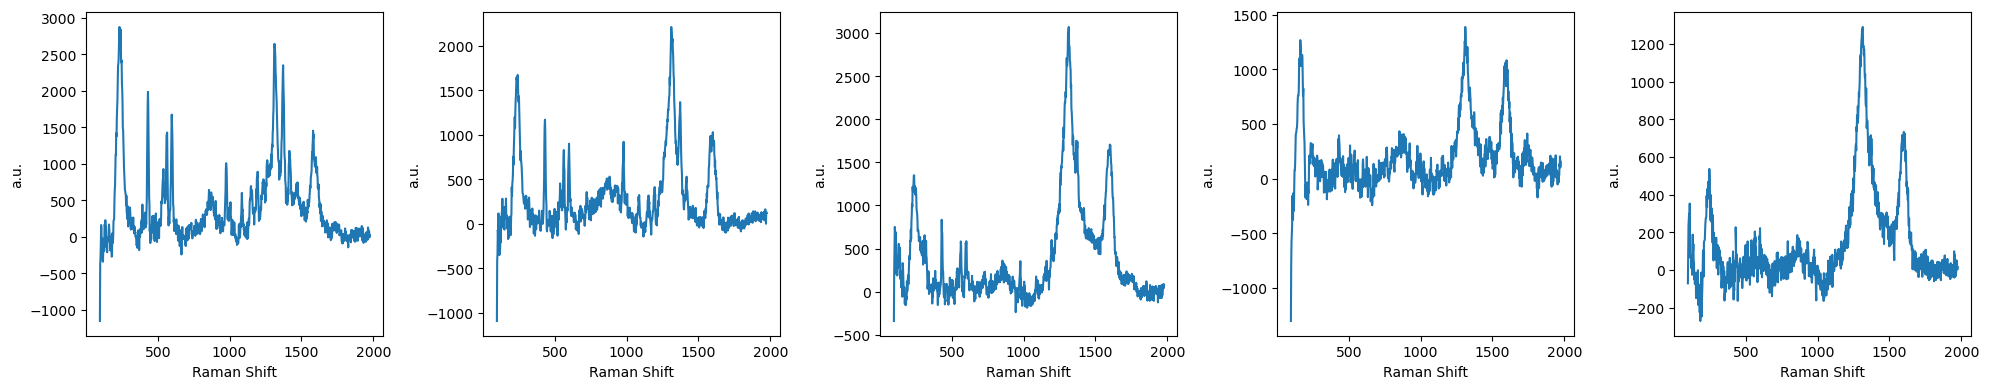

['Data-1', 'Data-2', 'Data-3', 'Data-4', 'Data-5']
0.0000005158
0.0000001509
0.0000000426
0.0000000110
0.0000000050


In [27]:
plot_Tricylazole(paths = Trycilazole, nrows=1, ncols=5, figsize = (20, 4))
print(Trycilazole_1)
for i in Cm:
    print(f"{i:.10f}")

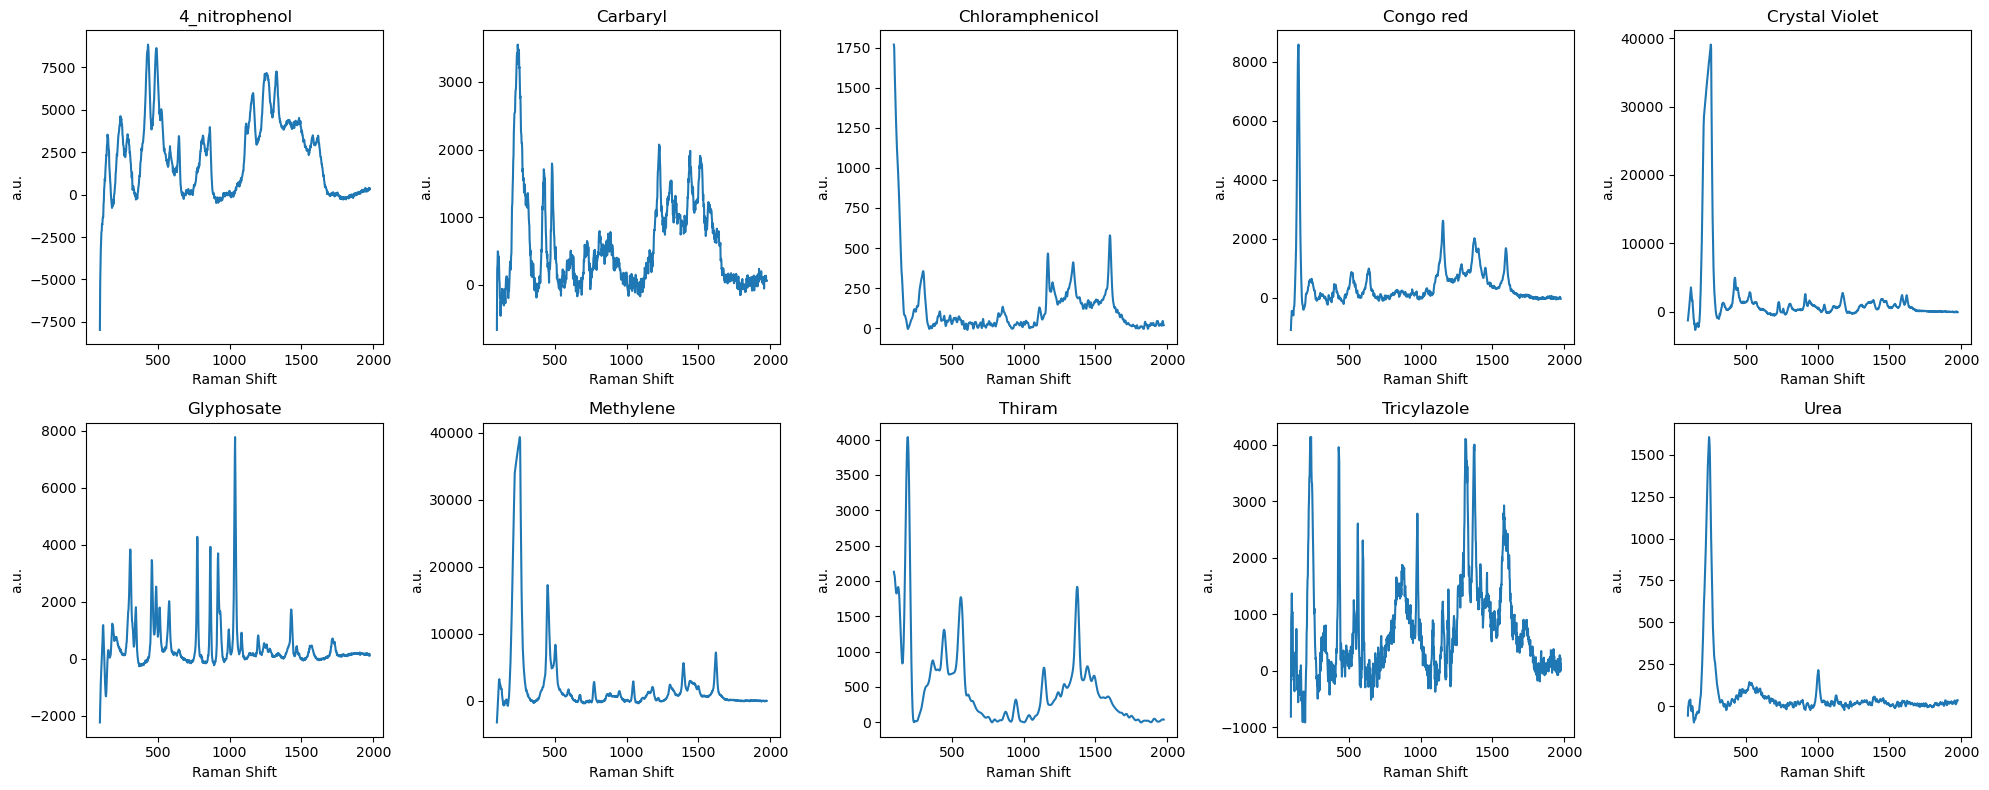

In [28]:
plot_data(paths, labels, file_names[0], 2, 5, figsize = (20, 8))

# Feature extraction PCA and training

In [29]:
X_mean = np.mean(X)
U = U_for_pca(X_train, X_mean, n_components = 3)
X_train_PCA = extract_PCA(X_train, X_mean, n_components=3)
# X_test_PCA = pca(X_test, X_mean, U)
X_test_PCA = extract_PCA(X_test, X_mean, n_components=3)

In [30]:
Grid_search_model(X_train_PCA,y_train, cv = 3)

Best parameters for Logistic Regression: {'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear'}, score: 0.53
Time taken for Logistic Regression: 0.05 seconds

Best parameters for SVM: {'C': 10.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': True}, score: 0.50
Time taken for SVM: 0.23 seconds

Best parameters for KNN: {'algorithm': 'auto', 'metric': 'cosine', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}, score: 0.60
Time taken for KNN: 1.25 seconds

Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'random'}, score: 0.53
Time taken for Decision Tree: 0.38 seconds

Best parameters for Random Forest: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 42}, score: 0.60
Time taken for Random Forest: 53.15 seconds

Best parameters for Naive Bayes: {'alpha': 0.01}, score: 0.27
Time taken for Naive Bayes: 0.01

In [31]:
models = [LogisticRegression(C = 10, penalty = 'l1', solver = 'liblinear'),
          SVC(C = 10, degree = 2, gamma = 'scale', shrinking = True,  probability=True, kernel = 'linear'),
          KNeighborsClassifier(algorithm = 'auto',p = 1, weights = 'uniform', n_neighbors = 3, metric = 'euclidean'),
          DecisionTreeClassifier(criterion= 'gini', max_depth= 8, min_samples_leaf= 2, min_samples_split = 2, splitter= 'best',  random_state = 42),
          RandomForestClassifier(criterion = 'gini', max_depth = 2, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 50,  random_state = 42),
          BernoulliNB(alpha=0.1)]

In [32]:
for i, model in enumerate(models):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_train_PCA, y_train)
    file_name = f"./model/PCA/{type(models[i]).__name__}.pkl"
    save_model(file_name, model)


Model './model/PCA/LogisticRegression.pkl' already saved
Model './model/PCA/SVC.pkl' already saved
Model './model/PCA/KNeighborsClassifier.pkl' already saved
Model './model/PCA/DecisionTreeClassifier.pkl' already saved
Model './model/PCA/RandomForestClassifier.pkl' already saved
Model './model/PCA/BernoulliNB.pkl' already saved


Testing with LogisticRegression
Accuracy: 0.0500
Precision: 0.0500
Recall: 0.0500
F1-score: 0.0500
[6. 6. 6. 4. 1. 8. 6. 8. 8. 8. 6. 6. 4. 6. 6. 6. 0. 8. 6. 1.]
[[0. 9. 3. 4. 8. 5. 2. 4. 6. 5. 2. 9. 7. 3. 0. 1. 8. 6. 1. 7.]]


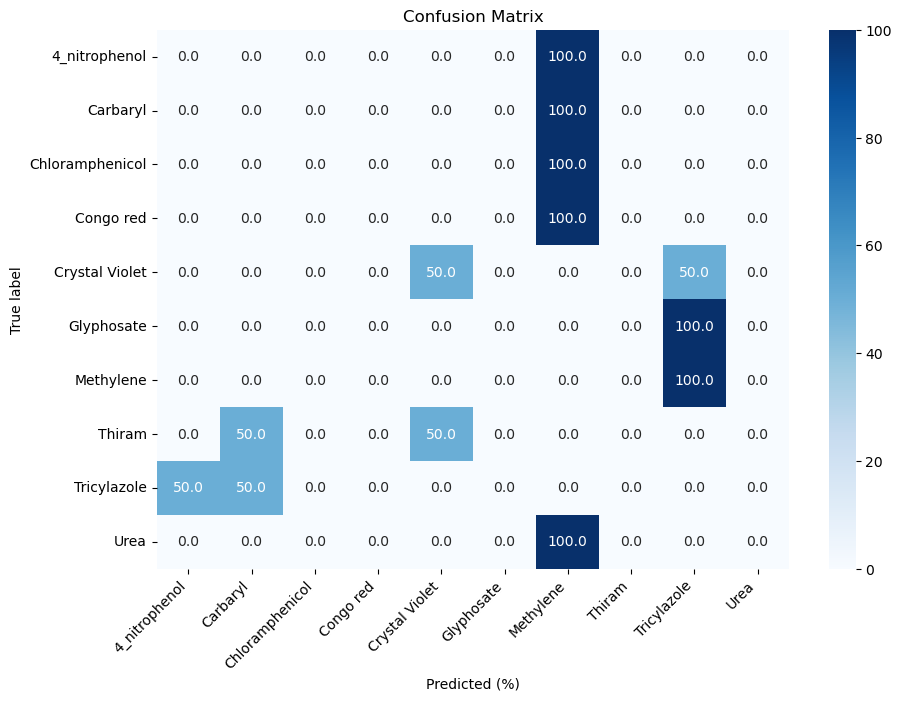

In [33]:
print(model_predict(X_test_PCA, y_test, models[0])['Predict'])
print(y_test.T)

# Feature extraction AutoEncoder and training

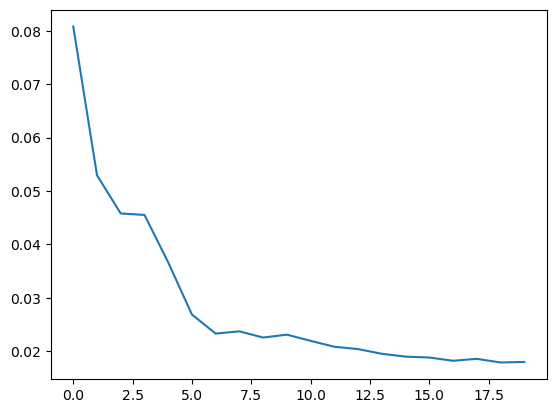

In [34]:
model = modelAE(X_train, out_features = 3, num_epochs = 20, learning_rate = 0.01)

In [35]:
X_train_AE = extractAE(model, X_train)
X_test_AE = extractAE(model, X_test)

In [36]:
Grid_search_model(X_train_AE,y_train, cv = 3)

Best parameters for Logistic Regression: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}, score: 0.23
Time taken for Logistic Regression: 0.06 seconds

Best parameters for SVM: {'C': 0.01, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'shrinking': True}, score: 0.30
Time taken for SVM: 0.23 seconds

Best parameters for KNN: {'algorithm': 'auto', 'metric': 'cosine', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}, score: 0.37
Time taken for KNN: 1.26 seconds

Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'random'}, score: 0.37
Time taken for Decision Tree: 0.37 seconds

Best parameters for Random Forest: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50, 'random_state': 42}, score: 0.40
Time taken for Random Forest: 54.01 seconds

Best parameters for Naive Bayes: {'alpha': 0.01}, score: 0.23
Time taken for Naive Bayes: 0.0

In [37]:
models = [LogisticRegression(C = 10, penalty = 'l1', solver = 'liblinear'),
          SVC(C = 10, degree = 2, gamma = 'scale', shrinking = True,  probability=True, kernel = 'linear'),
          KNeighborsClassifier(algorithm = 'auto',p = 1, weights = 'uniform', n_neighbors = 3, metric = 'euclidean'),
          DecisionTreeClassifier(criterion= 'entropy', max_depth= 4, min_samples_leaf= 1, min_samples_split = 2, splitter= 'best',  random_state = 42),
          RandomForestClassifier(criterion = 'gini', max_depth = 6, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 100,  random_state = 42),
          BernoulliNB(alpha=0.01)]

In [38]:
for i, model in enumerate(models):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_train_AE, y_train)
    file_name = f"./model/AutoEncoder/{type(models[i]).__name__}.pkl"
    save_model(file_name, model)

Model './model/AutoEncoder/LogisticRegression.pkl' already saved
Model './model/AutoEncoder/SVC.pkl' already saved
Model './model/AutoEncoder/KNeighborsClassifier.pkl' already saved
Model './model/AutoEncoder/DecisionTreeClassifier.pkl' already saved
Model './model/AutoEncoder/RandomForestClassifier.pkl' already saved
Model './model/AutoEncoder/BernoulliNB.pkl' already saved


Testing with LogisticRegression
Accuracy: 0.3000
Precision: 0.1833
Recall: 0.3000
F1-score: 0.2167
[7. 3. 3. 1. 8. 6. 9. 8. 6. 3. 9. 2. 3. 3. 0. 6. 0. 6. 3. 9.]
[[0. 9. 3. 4. 8. 5. 2. 4. 6. 5. 2. 9. 7. 3. 0. 1. 8. 6. 1. 7.]]


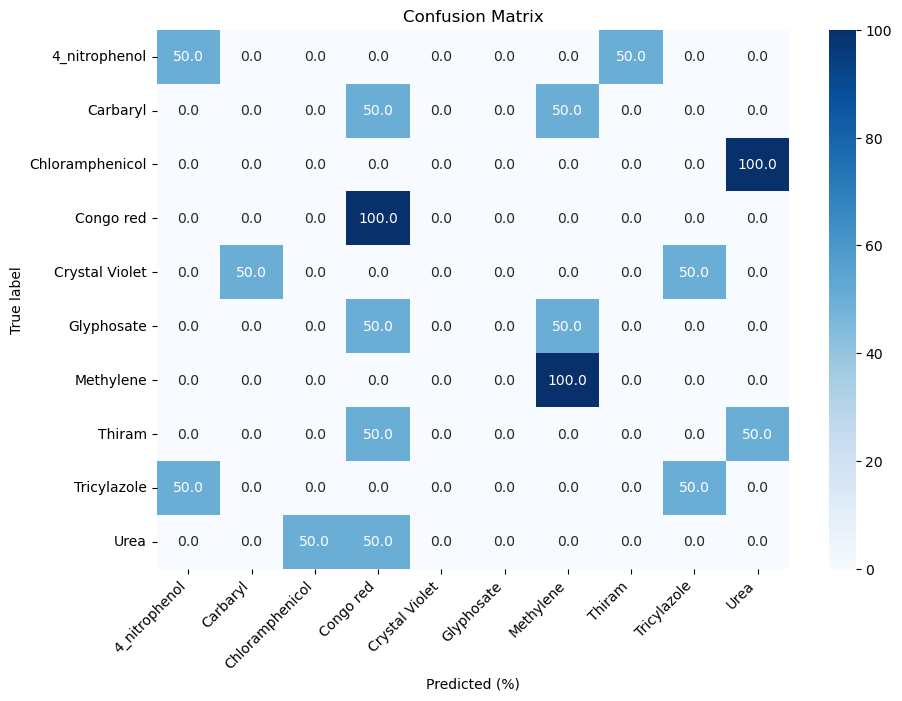

In [39]:
print(model_predict( X_test_AE, y_test, models[0])['Predict'])
print(y_test.T)

# Visualize

(50, 10) (50, 1)


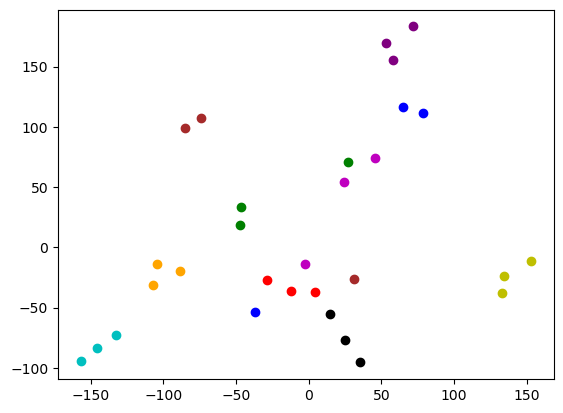

In [40]:
X, y = make_data(paths, 10)
print(X.shape, y.shape)
X_max = X.max(axis = 0, keepdims = True)
X_min = X.min(axis = 0, keepdims = True)
X = Norm(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.4, stratify=y, shuffle= True, random_state= 42)
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=4, random_state = 42)  

X_tsne = tsne.fit_transform(X_train)
visualize(X_tsne,y_train, option = "2d",eval = 50, azim =40, legend = False)

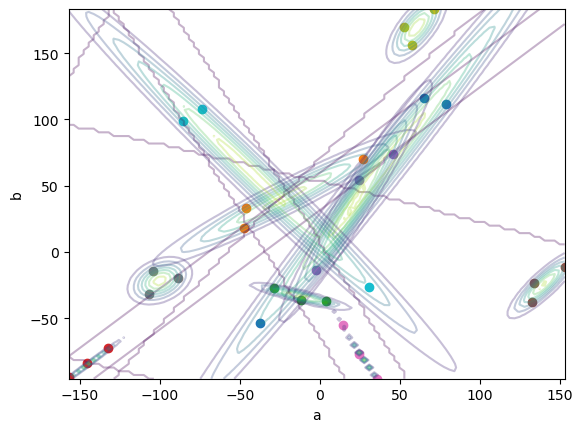

In [41]:
from scipy.stats import multivariate_normal
num_classes = 10

class_distributions = []
for i in range(num_classes):
    X_class = X_tsne[y_train.ravel() == i]
    class_mean = X_class.mean(axis=0)
    class_covariance = np.cov(X_class.T)
    class_distribution = multivariate_normal(mean=class_mean, cov=class_covariance)
    class_distributions.append(class_distribution)

a, b = np.meshgrid(np.linspace(X_tsne[:, 0].min(), X_tsne[:, 0].max(), 100), np.linspace(X_tsne[:, 1].min(), X_tsne[:, 1].max(), 100))
pos = np.dstack((a, b))

plt.xlabel("a")
plt.ylabel("b")
for i in range(num_classes):
    plt.contour(a, b, class_distributions[i].pdf(pos), alpha=0.3)
    plt.scatter(X_tsne[y_train.ravel() == i, 0], X_tsne[y_train.ravel() == i, 1], c=f"C{i}", label=f"Class {i}")

# plt.legend()
plt.show()

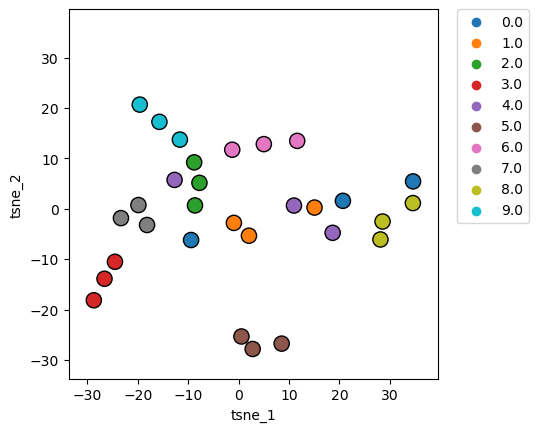

In [42]:
X, y = make_data(paths, 10)

X_max = X.max(axis = 0, keepdims = True)
X_min = X.min(axis = 0, keepdims = True)
X = Norm(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.4, stratify=y, shuffle= True, random_state= 42)
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=6, random_state = 42)  

X_tsne = tsne.fit_transform(X_train)

import seaborn as sn
tsne_result = X_tsne
tsne_result.shape

tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y_train.ravel()})

fig, ax = plt.subplots(1)
sn.scatterplot(x='tsne_1', y='tsne_2', hue='label', palette='tab10', data=tsne_result_df, ax=ax, s=120, edgecolor='black', linewidth=1)

lim = (X_tsne.min()-5, X_tsne.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

In [45]:
print(X_train.shape)

(30, 10)


/tmp/ipykernel_8477/2490934782.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab10')


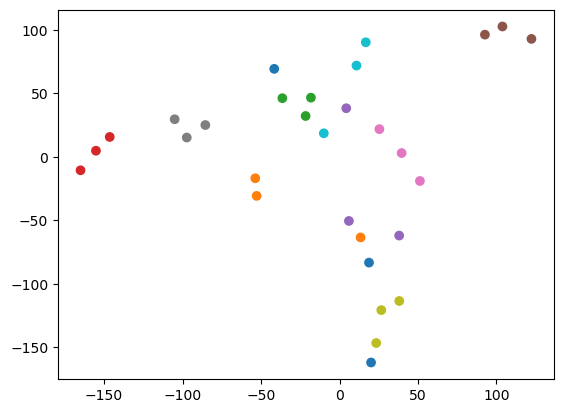

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from matplotlib.cm import get_cmap

tsne = TSNE(perplexity=4, random_state=0)
tsne_results = tsne.fit_transform(X_train)

tsne_results=pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])

cmap = get_cmap('tab10')

plt.scatter(tsne_results['tsne1'], tsne_results['tsne2'], c=y_train, cmap=cmap)
plt.show()


/tmp/ipykernel_8477/175908070.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab10')


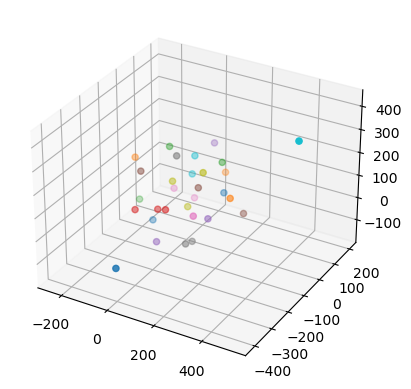

In [77]:
from mpl_toolkits.mplot3d import Axes3D


tsne = TSNE(n_components=3,perplexity=4, random_state=0)
tsne_results = tsne.fit_transform(X_train)


tsne_results = pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2', 'tsne3'])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

cmap = get_cmap('tab10')

scatter = ax.scatter(tsne_results['tsne1'], tsne_results['tsne2'], tsne_results['tsne3'], c=y_train, cmap=cmap)

plt.show()
